In [1]:
from scipy import io
import numpy as np

import matplotlib.pyplot as plt


from sklearn.gaussian_process import GaussianProcessRegressor
plt.style.use("seaborn")

from sklearn.gaussian_process.kernels import Matern, RBF, ConstantKernel, WhiteKernel


from scipy.linalg import cholesky, cho_factor, cho_solve

import scipy

/tmp/ipykernel_290373/1315796348.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


In [2]:
def get_data(filename, ndata):
    # 5->85x85, 6->71x71, 7->61x61, 10->43x43, 12->36x36, 14->31x31, 15->29x29
    r = 15
    s = int(((421 - 1) / r) + 1)

    # Data is of the shape (number of samples = 1024, grid size = 421x421)
    data = io.loadmat(filename)
    x_branch = data["coeff"][:ndata, ::r, ::r].astype(np.float64) * 0.1 - 0.75
    y = data["sol"][:ndata, ::r, ::r].astype(np.float64) * 100
    # The dataset has a mistake that the BC is not 0.
    y[:, 0, :] = 0
    y[:, -1, :] = 0
    y[:, :, 0] = 0
    y[:, :, -1] = 0

    grids = []
    grids.append(np.linspace(0, 1, s, dtype=np.float32))
    grids.append(np.linspace(0, 1, s, dtype=np.float32))
    grid = np.vstack([xx.ravel() for xx in np.meshgrid(*grids)]).T

    x_branch = x_branch.reshape(ndata, s * s)
    #x = (x_branch, grid)
    y = y.reshape(ndata, s * s)
    return x_branch, y, grid


x, y, grid = get_data("piececonst_r421_N1024_smooth1.mat", 1000)
x_test, y_test, grid = get_data("piececonst_r421_N1024_smooth2.mat", 200)



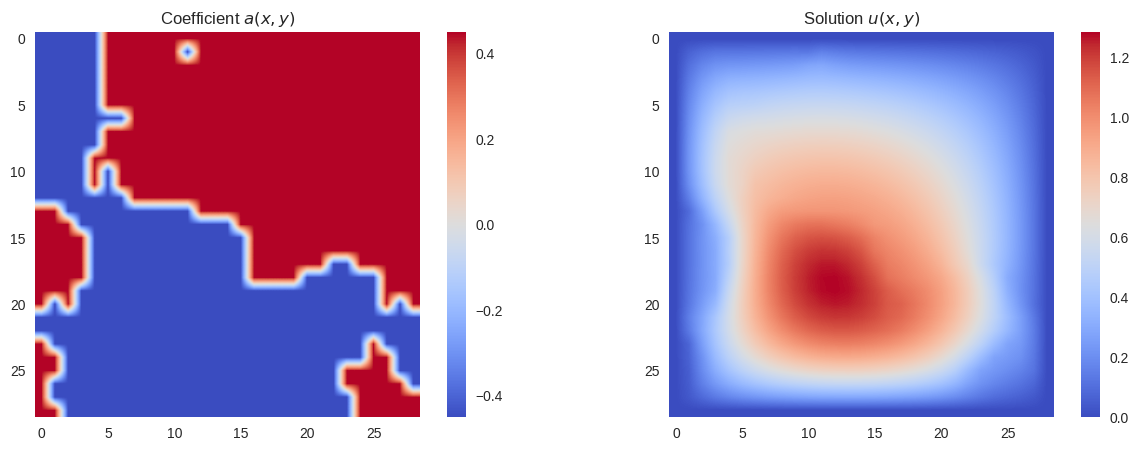

In [3]:
idx = 20
coef = x_test[idx].reshape(29,29)
sol = y_test[idx].reshape(29,29)

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,5))

im = ax1.imshow(coef, interpolation='bilinear', cmap= "coolwarm")
ax1.grid(visible=None)
fig.colorbar(im, ax=ax1)
ax1.set_title(r"Coefficient $a(x,y)$")

im = ax2.imshow(sol, interpolation='bilinear', cmap= "coolwarm")
ax2.grid(visible=None)
fig.colorbar(im, ax=ax2)
ax2.set_title(r"Solution $u(x,y)$")

plt.show()

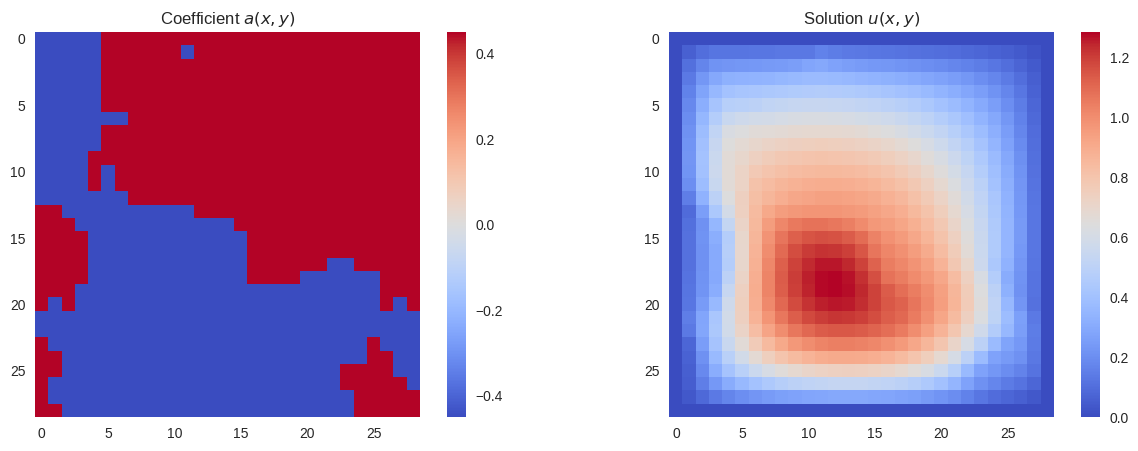

In [10]:
idx = 20
coef = x_test[idx].reshape(29,29)
sol = y_test[idx].reshape(29,29)

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,5))

im = ax1.imshow(coef, interpolation = 'nearest' , cmap= "coolwarm")
ax1.grid(visible=None)
fig.colorbar(im, ax=ax1)
ax1.set_title(r"Coefficient $a(x,y)$")

im = ax2.imshow(sol, cmap= "coolwarm")
ax2.grid(visible=None)
fig.colorbar(im, ax=ax2)
ax2.set_title(r"Solution $u(x,y)$")

plt.show()

# No cholesky preconditioning

In [4]:
def train_test(x_train, x_test, y_train, y_test):
    kernel = Matern(nu = 2.5, length_scale = 1.0)
    gp = GaussianProcessRegressor(kernel, alpha = 1e-10,  normalize_y = False, random_state= 6032023) 
    
    gp.fit(x_train, y_train)
    pred= gp.predict(x_test)
    #pred_train = gp.predict(x_train)

    #e = compute_error_dataset(y_test, pred, knots, k)

    return pred, gp

pred, GP = train_test(x, x_test, y, y_test)
pred_train = GP.predict(x)
e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))
e_train = np.mean(np.linalg.norm(pred_train - y, axis = -1)/np.linalg.norm(y, axis = -1))

print("Error without cholesky preconditioning")
print(e, e_train)
idx = 15
i = 0




Error without cholesky preconditioning
0.04473035477519126 6.003859086424181e-09


/tmp/ipykernel_252918/2191536796.py:17: RuntimeWarning: invalid value encountered in true_divide
  im = ax3.imshow(np.sqrt((sol - sol_pred)**2/(sol)**2), interpolation='bilinear', cmap= "coolwarm")


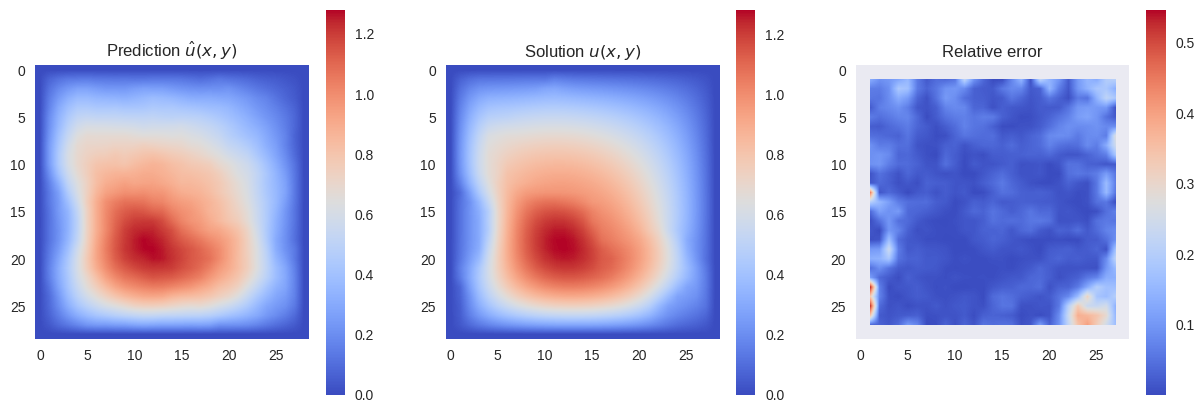

In [5]:
idx = 20
sol_pred = pred[idx].reshape(29,29)
sol = y_test[idx].reshape(29,29)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,5))

im = ax1.imshow(sol_pred, interpolation='bilinear', cmap= "coolwarm")
ax1.grid(visible=None)
fig.colorbar(im, ax=ax1)
ax1.set_title(r"Prediction $\hat{u}(x,y)$")

im = ax2.imshow(sol, interpolation='bilinear', cmap= "coolwarm")
ax2.grid(visible=None)
fig.colorbar(im, ax=ax2)
ax2.set_title(r"Solution $u(x,y)$")

im = ax3.imshow(np.sqrt((sol - sol_pred)**2/(sol)**2), interpolation='bilinear', cmap= "coolwarm")
ax3.grid(visible=None)
fig.colorbar(im, ax=ax3)
ax3.set_title(r"Relative error")

plt.show()

# More efficient code

In [6]:
def compute_cho(kernel_u, kernel_v, grid):
    K = kernel_u(grid)
    G = kernel_v(grid)
    #print(np.linalg.cond(K))

    tau = 1e-8
    L_K = cholesky(K + tau*np.eye(K.shape[0]), lower=True)
    L_G = cholesky(G+ tau*np.eye(G.shape[0]), lower = False)
    
    return L_K, L_G

def precondition(L_K, L_G, u ,v):
    tau = 1e-8
    L_G_inv = np.linalg.inv(L_G + tau*np.eye(L_G.shape[0]))    
    return (L_K.T @ u[:, :, None]).squeeze(-1), (L_G_inv.T @ v[:, :, None]).squeeze(-1)
    
def compute_error(prediction, target):
    e = np.mean(np.linalg.norm(prediction - target, axis = -1)/np.linalg.norm(target, axis = -1))
    
    return e

def optimal_recovery(K, G, L_K, L_G, u, v):
    tau = 0
    #L_K_inv = np.linalg.inv(L_K + tau*np.eye(K.shape[0]))
    L_G_inv = np.linalg.inv(L_G + tau*np.eye(K.shape[0]))
    
    u = np.linalg.solve(L_K.T, u[:, :, None]).squeeze(-1)
    #u_recov = np.squeeze(K@scipy.linalg.cho_solve((L_K, True), u[None] ))
    u_recov = np.squeeze(K@scipy.linalg.solve(K, u.T, assume_a = 'pos' )).T
    v_recov = np.squeeze(G@L_G_inv@v[:, :, None])
    
    return u_recov, v_recov
    

In [7]:
def train_test(x_train, x_test, y_train, y_test):
    kernel = Matern(nu = 1.5, length_scale = 1.0)
    gp = GaussianProcessRegressor(kernel, alpha = 1e-10,  normalize_y = False, random_state= 6032023) 
    
    gp.fit(x_train, y_train)
    pred= gp.predict(x_test)
    #pred_train = gp.predict(x_train)

    #e = compute_error_dataset(y_test, pred, knots, k)

    return pred, gp

In [8]:
kernel_u =Matern(nu = 0.5, length_scale = 0.041086609286226816) 
kernel_v = Matern(nu = 0.5, length_scale = 1e-10)
L_K, L_G = compute_cho(kernel_u, kernel_v, grid)

x_train, y_train = precondition(L_K, L_G, x, y)
x_val, y_val = precondition(L_K, L_G, x_test, y_test)


pred, gp = train_test(x_train, x_val, y_train, y_val)
pred_train = gp.predict(x_train)

e = compute_error(pred, y_val)
e_train = compute_error(pred_train, y_train)
print(e, e_train)

0.02916056012325603 7.269598494865998e-09


In [9]:
# pointwise prediction
K = kernel_u(grid)
G = kernel_v(grid)
_, pred_train_point = optimal_recovery(K, G, L_K, L_G, x_train, pred_train)
_, pred_point = optimal_recovery(K, G, L_K, L_G, x_val, pred)

e = compute_error(pred_point, y_test)
e_train = compute_error(pred_train_point, y)
print(e, e_train)

0.029160560405228155 2.1153246837019406e-08


/tmp/ipykernel_252918/4248991582.py:17: RuntimeWarning: invalid value encountered in true_divide
  im = ax3.imshow(np.sqrt((sol - sol_pred)**2/(sol)**2), interpolation='bilinear', cmap= "coolwarm")


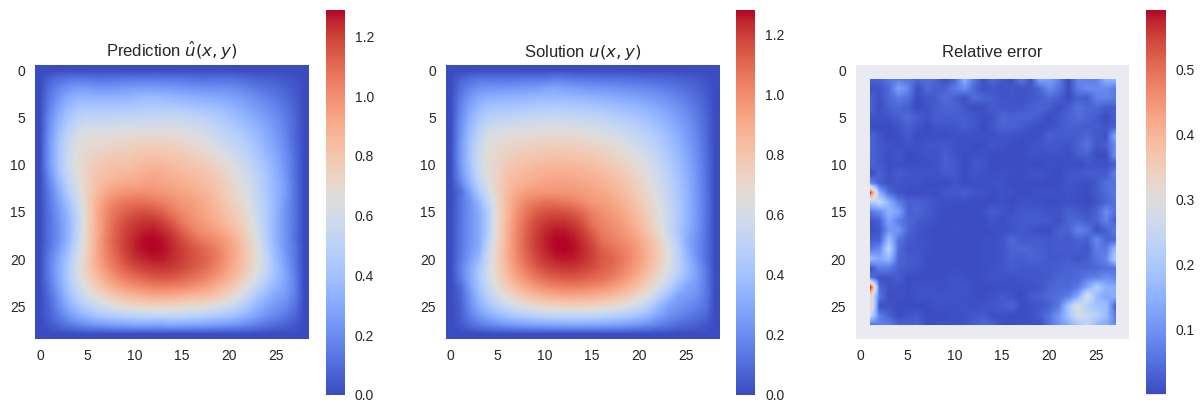

In [10]:
idx = 20
sol_pred = pred_point[idx].reshape(29,29)
sol = y_test[idx].reshape(29,29)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,5))

im = ax1.imshow(sol_pred, interpolation='bilinear', cmap= "coolwarm")
ax1.grid(visible=None)
fig.colorbar(im, ax=ax1)
ax1.set_title(r"Prediction $\hat{u}(x,y)$")

im = ax2.imshow(sol, interpolation='bilinear', cmap= "coolwarm")
ax2.grid(visible=None)
fig.colorbar(im, ax=ax2)
ax2.set_title(r"Solution $u(x,y)$")

im = ax3.imshow(np.sqrt((sol - sol_pred)**2/(sol)**2), interpolation='bilinear', cmap= "coolwarm")
ax3.grid(visible=None)
fig.colorbar(im, ax=ax3)
ax3.set_title(r"Relative error")

plt.show()

# More efficient code v2

In [24]:
def compute_cho(kernel_u, kernel_v, grid):
    K = kernel_u(grid)
    G = kernel_v(grid)
    #print(np.linalg.cond(K))

    tau = 1e-8
    L_K = cholesky(K + tau*np.eye(K.shape[0]), lower=True)
    G_inv = np.linalg.inv(G + tau*np.eye(G.shape[0]))   
    L_G = cholesky(G_inv+ tau*np.eye(G.shape[0]), lower = True)
    
    return L_K, L_G

def precondition(L_K, L_G, u ,v):
    tau = 1e-8
    L_G_inv = L_G
    return (L_K.T @ u[:, :, None]).squeeze(-1), (L_G_inv.T @ v[:, :, None]).squeeze(-1)
    
    
def compute_error(prediction, target):
    e = np.mean(np.linalg.norm(prediction - target, axis = -1)/np.linalg.norm(target, axis = -1))
    
    return e

def optimal_recovery(K, G, L_K, L_G, u, v):
    tau = 0
    #L_K_inv = np.linalg.inv(L_K + tau*np.eye(K.shape[0]))
    L_G_inv = L_G #np.linalg.inv(L_G + tau*np.eye(K.shape[0]))
    
    u = np.linalg.solve(L_K.T, u[:, :, None]).squeeze(-1)
    #u_recov = np.squeeze(K@scipy.linalg.cho_solve((L_K, True), u[None] ))
    u_recov = np.squeeze(K@scipy.linalg.solve(K, u.T, assume_a = 'pos' )).T
    v_recov = np.squeeze(G@L_G_inv@v[:, :, None])
    
    return u_recov, v_recov
    

In [25]:
def train_test(x_train, x_test, y_train, y_test):
    kernel = Matern(nu = 1.5, length_scale = 1.0)
    gp = GaussianProcessRegressor(kernel, alpha = 1e-10,  normalize_y = False, random_state= 6032023) 
    
    gp.fit(x_train, y_train)
    pred= gp.predict(x_test)
    #pred_train = gp.predict(x_train)

    #e = compute_error_dataset(y_test, pred, knots, k)

    return pred, gp

In [45]:
kernel_u =Matern(nu = 0.5, length_scale = 0.041086609286226816) 
kernel_v = Matern(nu = 0.5, length_scale = 0.1)
L_K, L_G = compute_cho(kernel_u, kernel_v, grid)

x_train, y_train = precondition(L_K, L_G, x, y)
x_val, y_val = precondition(L_K, L_G, x_test, y_test)


pred, gp = train_test(x_train, x_val, y_train, y_val)
pred_train = gp.predict(x_train)

e = compute_error(pred, y_val)
e_train = compute_error(pred_train, y_train)
print(e, e_train)

0.1107955530572617 8.824169580113871e-08


In [46]:
# pointwise prediction
K = kernel_u(grid)
G = kernel_v(grid)
_, pred_train_point = optimal_recovery(K, G, L_K, L_G, x_train, pred_train)
_, pred_point = optimal_recovery(K, G, L_K, L_G, x_val, pred)

e = compute_error(pred_point, y_test)
e_train = compute_error(pred_train_point, y)
print(e, e_train)

0.03011132314214442 4.007238575670992e-07


In [47]:
np.allclose(pred, pred_point) 

False

In [48]:
#pred_train = y_train
#pred = y_val
# pointwise prediction
K = kernel_u(grid)
G = kernel_v(grid)
_, pred_train_point = optimal_recovery(K, G, L_K, L_G, x_train, pred_train)
_, pred_point = optimal_recovery(K, G, L_K, L_G, x_val, pred)

e = compute_error(pred_point, y_test)
e_train = compute_error(pred_train_point, y)
print(e, e_train)

0.03011132314214442 4.007238575670992e-07


/tmp/ipykernel_252918/4248991582.py:17: RuntimeWarning: divide by zero encountered in true_divide
  im = ax3.imshow(np.sqrt((sol - sol_pred)**2/(sol)**2), interpolation='bilinear', cmap= "coolwarm")


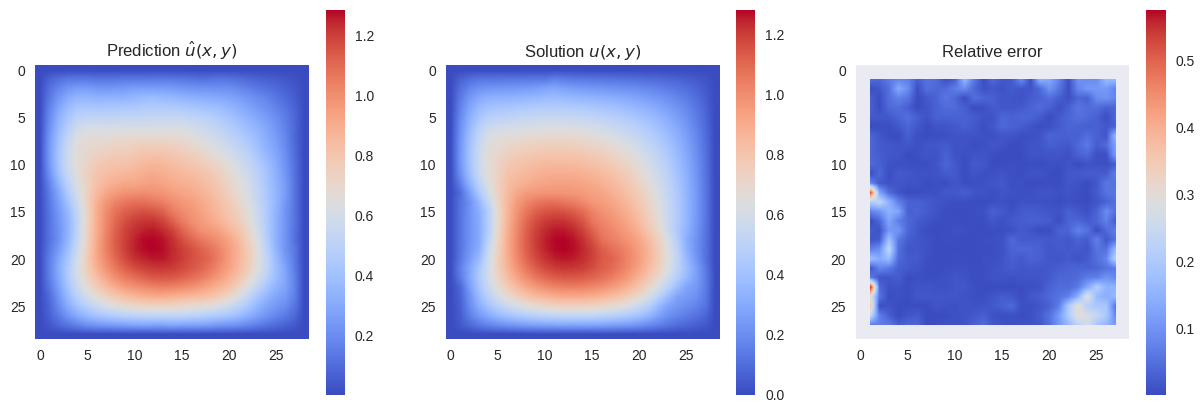

In [49]:
idx = 20
sol_pred = pred_point[idx].reshape(29,29)
sol = y_test[idx].reshape(29,29)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,5))

im = ax1.imshow(sol_pred, interpolation='bilinear', cmap= "coolwarm")
ax1.grid(visible=None)
fig.colorbar(im, ax=ax1)
ax1.set_title(r"Prediction $\hat{u}(x,y)$")

im = ax2.imshow(sol, interpolation='bilinear', cmap= "coolwarm")
ax2.grid(visible=None)
fig.colorbar(im, ax=ax2)
ax2.set_title(r"Solution $u(x,y)$")

im = ax3.imshow(np.sqrt((sol - sol_pred)**2/(sol)**2), interpolation='bilinear', cmap= "coolwarm")
ax3.grid(visible=None)
fig.colorbar(im, ax=ax3)
ax3.set_title(r"Relative error")

plt.show()

# Using bayesian optimization v2

In [50]:
from skopt import gp_minimize
from sklearn.model_selection import KFold

In [51]:
def f_cv(x, y, l_u,  l_v):
    
    kernel_u = Matern(nu = 0.5, length_scale = l_u) 
    kernel_v = Matern(nu = 0.5, length_scale = l_v)
    
    print(kernel_u, kernel_v)
    
    kf = KFold(n_splits=5)
    
    L_K, L_G = compute_cho(kernel_u, kernel_v, grid)
    
    #print(L_G[0])
    
    e = 0
    for train_index, test_index in kf.split(x):
        #print("TRAIN:", train_index, "TEST:", test_index)
        
        x_train, y_train = precondition(L_K, L_G, x[train_index], y[train_index])
        x_val, y_val = precondition(L_K, L_G, x[test_index], y[test_index])
        
        pred, gp = train_test(x_train, x_val, y_train, y_val)
        
        e += compute_error(pred, y_val)
    #print(e/5)
    return (e/5).item()

In [52]:
f_opt = lambda param: f_cv(x, y, param[0], param[1])

In [53]:
# Defining the search space

from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args

space= [ 
        Real(0.00001, 100.0, name='length_scale_u'),
        Real(0.00001, 100.0, name='length_scale_v')
         ]


In [54]:
x0 = [0.1, 0.001]
f_opt(x0)

Matern(length_scale=0.1, nu=0.5) Matern(length_scale=0.001, nu=0.5)


0.029640839412046288

In [55]:
n_calls = 100
n_start = 10

x0 = [0.1, 0.001]

space= [ 
        Real(0.00001, 1.0, name='length_scale_u'),
        Real(0.00001, 1.0, name='length_scale_v')
         ]

res = gp_minimize(f_opt,                  # the function to minimize
                  space,      # the bounds on each dimension of x
                  n_calls=n_calls,         # the number of evaluations of f
                  n_initial_points=n_start,  # the number of random initialization points
                  random_state=1234,
                 verbose = True,
                  x0 = x0
                 ) 

Iteration No: 1 started. Evaluating function at provided point.
Matern(length_scale=0.1, nu=0.5) Matern(length_scale=0.001, nu=0.5)
Iteration No: 1 ended. Evaluation done at provided point.
Time taken: 226.4272
Function value obtained: 0.0296
Current minimum: 0.0296
Iteration No: 2 started. Evaluating function at random point.
Matern(length_scale=0.498, nu=0.5) Matern(length_scale=0.818, nu=0.5)
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 31.7461
Function value obtained: 1.0000
Current minimum: 0.0296
Iteration No: 3 started. Evaluating function at random point.
Matern(length_scale=0.612, nu=0.5) Matern(length_scale=0.771, nu=0.5)
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 31.6999
Function value obtained: 1.0000
Current minimum: 0.0296
Iteration No: 4 started. Evaluating function at random point.
Matern(length_scale=0.861, nu=0.5) Matern(length_scale=0.151, nu=0.5)
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 31.71

Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 261.2768
Function value obtained: 0.2366
Current minimum: 0.0296
Iteration No: 32 started. Searching for the next optimal point.
Matern(length_scale=0.571, nu=0.5) Matern(length_scale=1e-05, nu=0.5)
Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 172.3433
Function value obtained: 0.2279
Current minimum: 0.0296
Iteration No: 33 started. Searching for the next optimal point.
Matern(length_scale=0.0687, nu=0.5) Matern(length_scale=1e-05, nu=0.5)
Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 227.2709
Function value obtained: 0.0294
Current minimum: 0.0294
Iteration No: 34 started. Searching for the next optimal point.
Matern(length_scale=0.932, nu=0.5) Matern(length_scale=0.00214, nu=0.5)
Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 224.4234
Function value obtained: 0.0364
Current minimum: 0.0294
Iteration No: 3

Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 190.9072
Function value obtained: 0.4689
Current minimum: 0.0294
Iteration No: 62 started. Searching for the next optimal point.
Matern(length_scale=0.736, nu=0.5) Matern(length_scale=0.918, nu=0.5)
Iteration No: 62 ended. Search finished for the next optimal point.
Time taken: 31.9973
Function value obtained: 1.0000
Current minimum: 0.0294
Iteration No: 63 started. Searching for the next optimal point.
Matern(length_scale=0.0347, nu=0.5) Matern(length_scale=0.0013, nu=0.5)
Iteration No: 63 ended. Search finished for the next optimal point.
Time taken: 173.2746
Function value obtained: 0.0312
Current minimum: 0.0294
Iteration No: 64 started. Searching for the next optimal point.
Matern(length_scale=0.196, nu=0.5) Matern(length_scale=0.598, nu=0.5)
Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 32.0666
Function value obtained: 1.0000
Current minimum: 0.0294
Iteration No: 65 s

/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 310.0205
Function value obtained: 0.0472
Current minimum: 0.0294
Iteration No: 84 started. Searching for the next optimal point.
Matern(length_scale=1, nu=0.5) Matern(length_scale=0.586, nu=0.5)
Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 169.4864
Function value obtained: 0.5950
Current minimum: 0.0294
Iteration No: 85 started. Searching for the next optimal point.
Matern(length_scale=0.0443, nu=0.5) Matern(length_scale=0.0181, nu=0.5)
Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 239.7690
Function value obtained: 0.0331
Current minimum: 0.0294
Iteration No: 86 started. Searching for the next optimal point.
Matern(length_scale=1e-05, nu=0.5) Matern(length_scale=0.766, nu=0.5)
Iteration No: 86 ended. Search finished for the next optimal point.
Time taken: 138.9051
Function value obtained: 0.2847
Current minimum: 0.0294
Iteration No: 87 sta

/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 225.3054
Function value obtained: 0.2723
Current minimum: 0.0294
Iteration No: 99 started. Searching for the next optimal point.
Matern(length_scale=0.161, nu=0.5) Matern(length_scale=0.391, nu=0.5)
Iteration No: 99 ended. Search finished for the next optimal point.
Time taken: 32.3402
Function value obtained: 1.0000
Current minimum: 0.0294
Iteration No: 100 started. Searching for the next optimal point.
Matern(length_scale=0.681, nu=0.5) Matern(length_scale=0.216, nu=0.5)
Iteration No: 100 ended. Search finished for the next optimal point.
Time taken: 32.3722
Function value obtained: 1.0000
Current minimum: 0.0294


In [56]:
param_opt = res.x
param_opt

[0.06867071982701294, 1e-05]

In [57]:
kernel_u =Matern(nu = 0.5, length_scale = param_opt[0]) 
kernel_v = Matern(nu = 0.5, length_scale = param_opt[1])

#kernel_v = WhiteKernel()


In [58]:
L_K, L_G = compute_cho(kernel_u, kernel_v, grid)

x_train, y_train = precondition(L_K, L_G, x, y)
x_val, y_val = precondition(L_K, L_G, x_test, y_test)


pred, gp = train_test(x_train, x_val, y_train, y_val)
pred_train = gp.predict(x_train)

e = compute_error(pred, y_val)
e_train = compute_error(pred_train, y_train)
print(e, e_train)

0.028066780351621957 8.177786556354613e-09


In [59]:
# pointwise prediction
K = kernel_u(grid)
G = kernel_v(grid)
_, pred_train_point = optimal_recovery(K, G, L_K, L_G, x_train, pred_train)
_, pred_point = optimal_recovery(K, G, L_K, L_G, x_val, pred)

e = compute_error(pred_point, y_test)
e_train = compute_error(pred_train_point, y)
print(e, e_train)

0.028066780351621957 8.177786556354613e-09


/tmp/ipykernel_252918/4248991582.py:17: RuntimeWarning: invalid value encountered in true_divide
  im = ax3.imshow(np.sqrt((sol - sol_pred)**2/(sol)**2), interpolation='bilinear', cmap= "coolwarm")


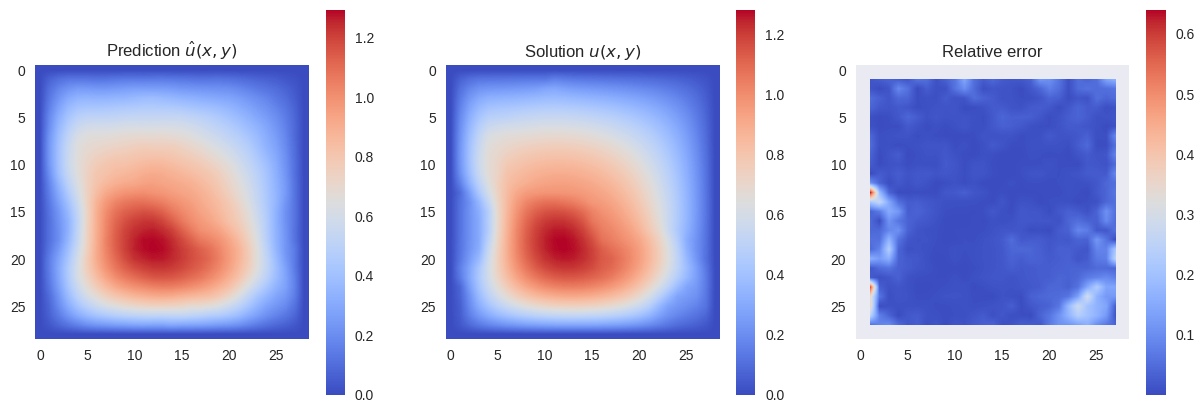

In [60]:
idx = 20
sol_pred = pred_point[idx].reshape(29,29)
sol = y_test[idx].reshape(29,29)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,5))

im = ax1.imshow(sol_pred, interpolation='bilinear', cmap= "coolwarm")
ax1.grid(visible=None)
fig.colorbar(im, ax=ax1)
ax1.set_title(r"Prediction $\hat{u}(x,y)$")

im = ax2.imshow(sol, interpolation='bilinear', cmap= "coolwarm")
ax2.grid(visible=None)
fig.colorbar(im, ax=ax2)
ax2.set_title(r"Solution $u(x,y)$")

im = ax3.imshow(np.sqrt((sol - sol_pred)**2/(sol)**2), interpolation='bilinear', cmap= "coolwarm")
ax3.grid(visible=None)
fig.colorbar(im, ax=ax3)
ax3.set_title(r"Relative error")

plt.show()

In [61]:
kernel_u =Matern(nu = 0.5, length_scale = param_opt[0]) 
#kernel_v = Matern(nu = 0.5, length_scale = param_opt[1])

kernel_v = WhiteKernel()


In [62]:
L_K, L_G = compute_cho(kernel_u, kernel_v, grid)

x_train, y_train = precondition(L_K, L_G, x, y)
x_val, y_val = precondition(L_K, L_G, x_test, y_test)


pred, gp = train_test(x_train, x_val, y_train, y_val)
pred_train = gp.predict(x_train)

e = compute_error(pred, y_val)
e_train = compute_error(pred_train, y_train)
print(e, e_train)

0.028066780351621957 8.177786556354613e-09


In [63]:
# pointwise prediction
K = kernel_u(grid)
G = kernel_v(grid)
_, pred_train_point = optimal_recovery(K, G, L_K, L_G, x_train, pred_train)
_, pred_point = optimal_recovery(K, G, L_K, L_G, x_val, pred)

e = compute_error(pred_point, y_test)
e_train = compute_error(pred_train_point, y)
print(e, e_train)

0.028066780351621957 8.177786556354613e-09


/tmp/ipykernel_252918/4248991582.py:17: RuntimeWarning: invalid value encountered in true_divide
  im = ax3.imshow(np.sqrt((sol - sol_pred)**2/(sol)**2), interpolation='bilinear', cmap= "coolwarm")


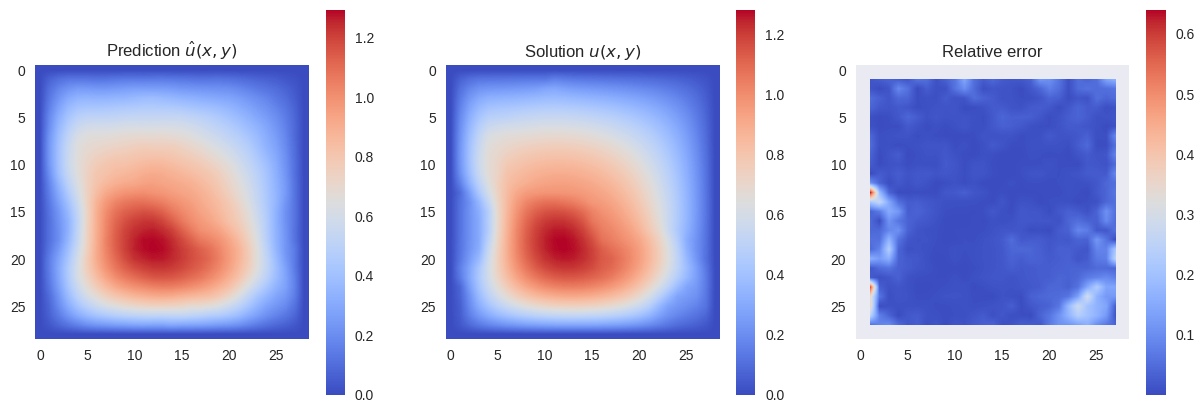

In [64]:
idx = 20
sol_pred = pred_point[idx].reshape(29,29)
sol = y_test[idx].reshape(29,29)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,5))

im = ax1.imshow(sol_pred, interpolation='bilinear', cmap= "coolwarm")
ax1.grid(visible=None)
fig.colorbar(im, ax=ax1)
ax1.set_title(r"Prediction $\hat{u}(x,y)$")

im = ax2.imshow(sol, interpolation='bilinear', cmap= "coolwarm")
ax2.grid(visible=None)
fig.colorbar(im, ax=ax2)
ax2.set_title(r"Solution $u(x,y)$")

im = ax3.imshow(np.sqrt((sol - sol_pred)**2/(sol)**2), interpolation='bilinear', cmap= "coolwarm")
ax3.grid(visible=None)
fig.colorbar(im, ax=ax3)
ax3.set_title(r"Relative error")

plt.show()